In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from pytictoc import TicToc
import datetime

import numpy as np
import matplotlib.pyplot as plt

import csv

In [3]:
%config InlineBackend.figure_format = 'svg'

params = {'figure.figsize': [5, 5],
    'axes.labelsize': 20,
    'axes.titlesize':24,
    'font.size': 20,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
}
plt.rcParams.update(params)

In [4]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [5]:
CONTINUE_TRAINING = False

In [6]:
N_RUN = 1

In [7]:
# Number of epochs
num_epochs = 200

## Load Data

In [8]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [9]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

## Networks

In [10]:
if CONTINUE_TRAINING:
    pretrained_model_D = "data/models/VGAN/MNIST/D_epoch_" + str((N_RUN-1) * num_epochs - 1)
    pretrained_model_G = "data/models/VGAN/MNIST/G_epoch_" + str((N_RUN-1) * num_epochs - 1)

In [11]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [12]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [13]:
use_cuda = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [14]:
# discriminator = DiscriminatorNet().to(device)
discriminator = DiscriminatorNet()
if CONTINUE_TRAINING:
    discriminator.load_state_dict(torch.load(pretrained_model_D, map_location='cuda'))
# discriminator.eval()     # <--- do NOT use this command to resume a training step

In [15]:
# generator = GeneratorNet().to(device)
generator = GeneratorNet()
if CONTINUE_TRAINING:
    generator.load_state_dict(torch.load(pretrained_model_G, map_location='cuda'))
# generator.eval()     # <--- do NOT use this command to resume a training step

In [16]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

/home/tito/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU1 GeForce GT 640 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Optimization

In [17]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00020)
g_optimizer = optim.Adam(generator.parameters(), lr=0.00025)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1


## Training

In [18]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

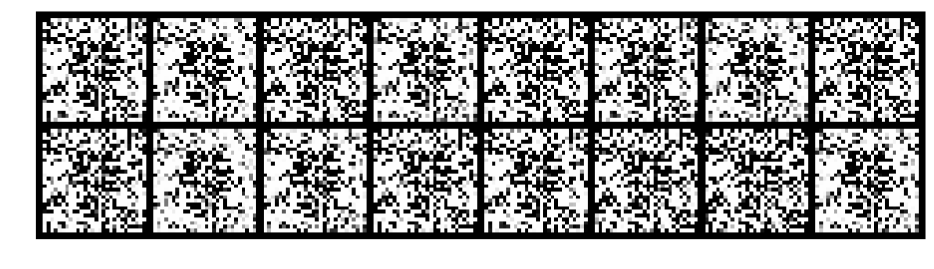

Epoch: [176/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 69.1517
D(x): 1.0000, D(G(z)): 0.0000
Epoch 176, Batch 400 took 	 7.908597 seconds.
Until now:	 2:26:07.119402


In [ ]:
%%time

t = TicToc()

t.tic()

TV = 0
timing = []

logger = Logger(model_name='VGAN', data_name='MNIST')

d_error_epochs = []
g_error_epochs = []
d_pred_real_epochs = []
d_pred_fake_epochs = []

for epoch in range((N_RUN - 1) * num_epochs + 1, (N_RUN-1) * num_epochs + num_epochs + 1):
    
    d_error_batches = []
    g_error_batches = []
    d_pred_real_batches = []
    d_pred_fake_batches = []
    
    for n_batch, (real_batch,_) in enumerate(data_loader, 1):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs * N_RUN, n_batch, num_batches,
                float(d_error), float(g_error), d_pred_real, d_pred_fake
            )
            
            TV = TV + t.tocvalue()
            t.toc('Epoch %d, Batch %d took \t' % (epoch, n_batch), restart=True)
            print("Until now:\t {:0>8}".format(str(datetime.timedelta(seconds=TV))))
            
            timing.append(TV)
            
#         print('d_pred_real_batches shape: ', np.array(d_pred_real_batches).shape)
#         print('d_pred_fake_batches shape: ', np.array(d_pred_fake_batches).shape)
            
        d_error_batches.append(d_error.tolist())
        g_error_batches.append(g_error.tolist())
        d_pred_real_batches.append(d_pred_real.data.tolist())
        d_pred_fake_batches.append(d_pred_fake.data.tolist())
        
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
        
#     print('d_pred_real_epochs shape: ', np.array(d_pred_real_epochs).shape)
#     print('d_pred_fake_epochs shape: ', np.array(d_pred_fake_epochs).shape)
        
    d_error_epochs.append(d_error_batches)
    g_error_epochs.append(g_error_batches)
    d_pred_real_epochs.append(d_pred_real_batches)
    d_pred_fake_epochs.append(d_pred_fake_batches)

In [ ]:
len(d_pred_real_epochs)

In [ ]:
d_error_batches_array = np.array(d_error_batches)
d_error_batches_array.shape

In [ ]:
d_error_epochs_array = np.array(d_error_epochs)
d_error_epochs_array.shape

In [ ]:
g_error_batches_array = np.array(g_error_batches)
g_error_batches_array.shape

In [ ]:
g_error_epochs_array = np.array(g_error_epochs)
g_error_epochs_array.shape

In [ ]:
d_pred_real_epochs_array = np.array(d_pred_real_epochs)
d_pred_real_epochs_array.shape

In [ ]:
d_pred_fake_epochs_array = np.array(d_pred_fake_epochs)
d_pred_fake_epochs_array.shape

In [ ]:
new_d_pred_real_epochs_array = d_pred_real_epochs_array.reshape((200, 600, 100))
new_d_pred_fake_epochs_array = d_pred_fake_epochs_array.reshape((200, 600, 100))

prob_real = []
for i in new_d_pred_real_epochs_array:
    tmpReal = []
    for j in i:
        tmpReal.append(j[0])
    prob_real.append(np.mean(tmpReal))
prob_real = np.array(prob_real)

prob_fake = []
for i in new_d_pred_fake_epochs_array:
    tmpFake = []
    for j in i:
        tmpFake.append(j[0])
    prob_fake.append(np.mean(tmpFake))
prob_fake = np.array(prob_fake)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(prob_real.shape[0] + ((N_RUN-2) * num_epochs), prob_real.shape[0] + ((N_RUN-1) * num_epochs) - 1,prob_real.shape[0]), prob_real, LineWidth=3, label='real')
plt.plot(np.linspace(prob_fake.shape[0] + ((N_RUN-2) * num_epochs), prob_fake.shape[0] + ((N_RUN-1) * num_epochs) - 1,prob_fake.shape[0]), prob_fake, LineWidth=3, label='fake')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.xlim(200, 400)
plt.ylim(0,1)
plt.xticks([200, 250, 300, 350, 400])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid(True)
plt.legend()
plt.savefig('uncertainty_' + str(N_RUN * 200) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_pred_fake_epochs_array = np.array(d_pred_fake_epochs)
d_pred_fake_epochs_array.shape

In [ ]:
# d_pred_real_array = np.array(d_pred_real.tolist())
# d_pred_real_array = d_pred_real_array.reshape(d_pred_real_array.shape[0])

# d_pred_fake_array = np.array(d_pred_fake.tolist())
# d_pred_fake_array = d_pred_fake_array.reshape(d_pred_fake_array.shape[0])

In [ ]:
csvfile = "d_error_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(d_error_epochs)
    
csvfile = "g_error_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(g_error_epochs)
    
csvfile = "d_pred_real_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_real:
        writer.writerow([val])
        
csvfile = "d_pred_fake_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_fake:
        writer.writerow([val])

In [ ]:
d_error_epochs_array = np.array(d_error_epochs)
new_d_error_epochs_array = np.array([np.mean(d_error_epochs_array[i,:]) for i in range(d_error_epochs_array.shape[0])])

g_error_epochs_array = np.array(g_error_epochs)
new_g_error_epochs_array = np.array([np.mean(g_error_epochs_array[i,:]) for i in range(g_error_epochs_array.shape[0])])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(d_error_epochs_array.shape[0]), new_d_error_epochs_array, LineWidth=3, label='discriminator')
plt.plot(range(g_error_epochs_array.shape[0]), new_g_error_epochs_array, LineWidth=3, label='generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 200)
plt.ylim(0, 4)
plt.grid(True)
plt.legend()
plt.savefig('loss_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(range(d_pred_real_array.shape[0]), d_pred_real_array, LineWidth=3, label='real')
# plt.plot(range(d_pred_fake_array.shape[0]), d_pred_fake_array, LineWidth=3, label='fake')
# plt.xlabel('Epoch')
# plt.ylabel('Uncertainty')
# plt.xlim(0,200)
# plt.grid(True)
# plt.legend()
# plt.savefig('uncertainty_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
new_timing = []
new_timing_mean = []
new_timing_sum = []

for i in range(int(len(timing)/6)):
    new_timing.append(timing[i:i+6])
    new_timing_mean.append(np.mean(timing[i:i+6]))
    new_timing_sum.append(np.sum(timing[i:i+6]))
    
new_timing = np.array(new_timing)
new_timing_mean = np.array(new_timing_mean)
new_timing_sum = np.array(new_timing_sum)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(new_timing_mean.shape[0]), new_timing_mean, LineWidth=3, label='Mean Epoch Time')
plt.plot(range(new_timing_sum.shape[0]), new_timing_sum, LineWidth=3, label='Total Epoch Time' )
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Processing Time [seconds]')
plt.xlim(0,200)
plt.ylim(0, 12000)
plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0, 4000, 8000, 12000])
plt.grid(True)
plt.savefig('timing_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
new_timing_mean.shape

In [ ]:
T = [0]
T_tmp = [new_timing_mean[i+1] - new_timing_mean[i] for i in range(new_timing_mean.shape[0]-1)]
T.extend(T_tmp)
T = np.array(T)

csvfile = "T_" + str(N_RUN * num_epochs) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in T:
        writer.writerow([val])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(T.shape[0]), T, LineWidth=3, label='Processing Time')
plt.hlines(np.mean(T), xmin=0, xmax=200, LineWidth=3, color='r', label='Mean (%.2f s)'%np.mean(T))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Processing Time [s]')
plt.xlim(0,200)
plt.ylim(0, 12)
plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0, 2, 4, 6, 8, 10, 12])
plt.grid(True)
plt.savefig('T_' + str(N_RUN * num_epochs) + '.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()